In [73]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import csv
import math
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

def clearData(data):
    # First changin ? with orderDate + Mean
    clearedDataFirst = [list(d) if list(d)[1] != "?" else [list(d)[0],(datetime.strptime(list(d)[0], '%Y-%m-%d') + timedelta(days=1)).strftime("%Y-%m-%d") ]  for d in zip(data['orderDate'], data['deliveryDate']) ]
    # Second changing 1990 with orderDate + Mean
    clearedTimeDataSecond = [d if datetime.strptime(list(d)[0], '%Y-%m-%d') <= datetime.strptime(list(d)[1], '%Y-%m-%d') else [d[0],(datetime.strptime(list(d)[0], '%Y-%m-%d') + timedelta(days=1)).strftime("%Y-%m-%d")] for d in clearedDataFirst]
    data["deliveryDate"] = [row[1] for row in clearedTimeDataSecond]

    # Clearing the birthdate data
    allDataFirstAgeChanged = [d if d != "?" else (datetime.strptime("2014-01-01", '%Y-%m-%d') - timedelta(days=48)).strftime('%Y-%m-%d') for d in data['dateOfBirth']   ]
    allDataAllAgeChanged = [d if datetime.strptime(d, '%Y-%m-%d') > datetime.strptime("1920-01-01", '%Y-%m-%d') and datetime.strptime(d, '%Y-%m-%d') < datetime.strptime("2000-01-01", '%Y-%m-%d') else (datetime.strptime("2014-01-01", '%Y-%m-%d') - timedelta(days=30*365.2)).strftime('%Y-%m-%d') for d in allDataFirstAgeChanged]
    data["dateOfBirth"] = allDataAllAgeChanged
    
    
    # salut
    salutArray = list(data["salutation"].unique())
    data["salutation"] = [salutArray.index(i) for i in data["salutation"]]
    
    # state
    stateArray = list(data["state"].unique())
    data["state"] = [stateArray.index(i) for i in data["state"]]
    
    accountAgeF = np.array([round((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1)) for d in data["creationDate"]])
    data["accountAge"] = accountAgeF
    
    ageNumF = np.array([round(((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365) for d in data['dateOfBirth']])
    data["age"] = ageNumF
    
    
    return data

def calculateRisk(r0, r1):
    c = 1.49615
    return 1- ((r0**c + 50) / ((r0+r1)**c + 100))


def createFeautre(data, rDict, pDict, mDict, cDict, aaDict, aDict):
    # Feature 1, if taken date > 10 1, else 0
    shipmentDateF = np.array([math.floor((datetime.strptime(list(d)[1], '%Y-%m-%d')-datetime.strptime(list(d)[0], '%Y-%m-%d')) / timedelta (days=1)) for d in zip(data['orderDate'], data['deliveryDate'])])

    # Feature 2 - specialDateChrismass, if order is close to speacial date and came late it is 1
    # Feature 3 - specialDateOthers, if order is close to speacial date and came late it is 1
    dateRepresentationOfData = [ [(int('%02d' % datetime.strptime(list(d)[0], '%Y-%m-%d').day),int('%02d' % datetime.strptime(list(d)[0], '%Y-%m-%d').month)), (int('%02d' % datetime.strptime(list(d)[1], '%Y-%m-%d').day),int('%02d' % datetime.strptime(list(d)[1], '%Y-%m-%d').month))] for d in zip(data['orderDate'], data['deliveryDate'])]
    specialDateChristmasF = np.array([1 if (d[0][0] > 14 and d[0][0] < 22 and d[0][1] == 12) and (d[1][0] >= 1 and d[1][1] >= 1) else 0 for d in dateRepresentationOfData])
    specialDateOthersF = np.array([1 if (d[0][0] > 3 and d[0][0] < 11 and d[0][1] == 5) and (d[1][0] >= 15 and d[1][1] >= 5) or (d[0][0] > 8 and d[0][0] < 14 and d[0][1] == 2) and (d[1][0] >= 18 and d[1][1] >= 2) else 0 for d in dateRepresentationOfData])

    # Feature 4 
    ageNummArray = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data['dateOfBirth']]
    ageNumF = np.array([ 0 if d < 20 else 1 for d in ageNummArray])
    
    # Feature 5
    accountAge = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1)) for d in data["creationDate"]]
    accountAgeF = np.array([0 if d < 450 else 1 for d in accountAge])

    ageNumF = np.array([calculateRisk(aDict[str(d) + "-0"], aDict[str(d) + "-1"]) for d in data['age'] ])
    
    accountAgeF = np.array([calculateRisk(aaDict[str(d) + "-0"], aaDict[str(d) + "-1"]) for d in data['accountAge'] ])
    
    # Feature 6 manufacturer id mean value
    manuReturnRateF = np.array([calculateRisk(mDict[str(d) + "-0"], mDict[str(d) + "-1"]) for d in data['manufacturerID'] ])


    # Feature 7 costumer id mean value
    userReturnRateF = np.array([calculateRisk(cDict[str(d) + "-0"], cDict[str(d) + "-1"]) for d in data['customerID'] ])


    
    # Feature 8 risk
    rZeroF = np.array([calculateRisk(rDict[str(d) + "-0"], rDict[str(d) + "-1"]) for d in data['itemID'] ])
    
    # Feature 9 price
    priceF = np.array([list(d)[1]/pDict[str(list(d)[0])] for d in zip(data['itemID'],data['price'])])
    
    
    

            
        
    
    return  np.vstack((shipmentDateF, specialDateChristmasF, specialDateOthersF, ageNumF, accountAgeF, manuReturnRateF, userReturnRateF, rZeroF, priceF, data['manufacturerID'], data['customerID'],data['itemID'])).T
    

In [74]:
data = clearData(pd.read_csv('train.txt', sep=","))

In [75]:
targetVal = data["returnShipment"]
dataVal = data.drop('returnShipment', 1)

data

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,accountAge,age
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,0,1965-01-06,0,2011-04-25,0,982,49
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,0,1965-01-06,0,2011-04-25,1,982,49
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,0,1965-01-06,0,2011-04-25,1,982,49
3,4,2012-04-02,2012-04-03,22,m,green,14,39.90,808,0,1959-11-09,1,2012-01-04,0,728,54
4,5,2012-04-02,2012-04-03,151,39,black,53,29.90,825,0,1964-07-11,2,2011-02-16,0,1050,50
5,6,2012-04-02,2012-04-03,598,xxl,brown,87,89.90,825,0,1964-07-11,2,2011-02-16,0,1050,50
6,7,2012-04-02,2012-04-03,15,39,black,1,129.90,825,0,1964-07-11,2,2011-02-16,0,1050,50
7,8,2012-04-02,2012-04-03,32,xxl,brown,3,21.90,850,0,1948-04-08,3,2011-02-16,1,1050,66
8,9,2012-04-02,2012-04-03,32,xxl,red,3,21.90,850,0,1948-04-08,3,2011-02-16,1,1050,66
9,10,2012-04-02,2012-04-03,57,xxl,green,3,39.90,850,0,1948-04-08,3,2011-02-16,1,1050,66


In [76]:
rDict = {}
for i in range(3705):
    rDict[str(i) + "-0"] = 0
    rDict[str(i) + "-1"] = 0
grouped_df = data.groupby(['itemID', 'returnShipment'])['itemID', 'returnShipment']
for key, item in grouped_df:
    rDict[str(key[0]) + "-" + str(key[1])] = len(grouped_df.get_group(key))
    
    
pDict = {}
for i in range(4000):
    pDict[str(i)] = (1, 1)    
grouped_df = data.groupby(['itemID', 'price'])['itemID', 'price']

for key, item in grouped_df:
    pDict[str(key[0])] = (pDict[str(key[0])][0]+key[1], pDict[str(key[0])][1] + 1)


for key, item in pDict.items():
    if item[1] == 1:
        pDict[key] = item[0]
    if item[1] != 1:
        pDict[key] = item[0]/(item[1]-1)
    

mDict = {}
for i in range(200):
    mDict[str(i) + "-0"] = 0
    mDict[str(i) + "-1"] = 0
grouped_df = data.groupby(['manufacturerID', 'returnShipment'])['manufacturerID', 'returnShipment']
for key, item in grouped_df:
    mDict[str(key[0]) + "-" + str(key[1])] = len(grouped_df.get_group(key))
    
    
aaDict = {}
for i in range(10000):
    aaDict[str(i) + "-0"] = 0
    aaDict[str(i) + "-1"] = 0
grouped_df = data.groupby(['accountAge', 'returnShipment'])['accountAge', 'returnShipment']
for key, item in grouped_df:
    aaDict[str(key[0]) + "-" + str(key[1])] = len(grouped_df.get_group(key))
    
    
aDict = {}
for i in range(200):
    aDict[str(i) + "-0"] = 0
    aDict[str(i) + "-1"] = 0
grouped_df = data.groupby(['age', 'returnShipment'])['age', 'returnShipment']
for key, item in grouped_df:
    aDict[str(key[0]) + "-" + str(key[1])] = len(grouped_df.get_group(key))
    
    
cDict = {}
for i in range(92000):
    cDict[str(i) + "-0"] = 0
    cDict[str(i) + "-1"] = 0
grouped_df = data.groupby(['customerID', 'returnShipment'])['customerID', 'returnShipment']
for key, item in grouped_df:
    cDict[str(key[0]) + "-" + str(key[1])] = len(grouped_df.get_group(key))

In [77]:
# Creating train matrix
trainMatrix = createFeautre(data, rDict, pDict, mDict, cDict, aaDict, aDict)
# Creating label array
labelArray = np.array(data['returnShipment'])



In [78]:
testData = clearData( pd.read_csv('test.txt', sep=","))

In [79]:
rDictTest = {}
for i in range(4000):
    rDictTest[str(i) + "-0"] = 0.5
    rDictTest[str(i) + "-1"] = 0.5

for key, item in rDict.items():
    rDictTest[key] = item

In [80]:
testMatrix = createFeautre(testData, rDictTest, pDict, mDict, cDict, aaDict, aDict)

In [81]:
# Logistic
logisticRegr = LogisticRegression()
logisticRegr.fit(trainMatrix, labelArray)
predictLogistic = logisticRegr.predict(testMatrix)

In [82]:
# Gauss
clf = GaussianNB()
clf.fit(trainMatrix, labelArray)
predictGauss = clf.predict(testMatrix)


In [83]:
# RF
rf = RandomForestClassifier()
rf.fit(trainMatrix, labelArray)
predictRF = rf.predict(testMatrix)


In [84]:
# decision tree
dtc = DecisionTreeClassifier()
dtc.fit(trainMatrix, labelArray)
predictdtc = dtc.predict(testMatrix)

In [85]:
voting = VotingClassifier(estimators=[ ('lr', logisticRegr), ('rf', rf), ('dtc', dtc)], voting='soft', weights=[2,4,6], flatten_transform=True)
voting.fit(trainMatrix, labelArray)
predictvoting = dtc.predict(testMatrix)

In [86]:
myData = [["orderItemID", "returnShipment"]] + [[str(i+1), str(e)] for i,e in enumerate(predictvoting)]

myFile = open('predictFINAL.csv', 'w')
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(myData)
     
print("Writing complete")

Writing complete


In [87]:
from sklearn.metrics import accuracy_score
trainErrorRF = rf.predict(trainMatrix)
trainErrorDTC = dtc.predict(trainMatrix)
trainErrorG = clf.predict(trainMatrix)
trainErrorLog = logisticRegr.predict(trainMatrix)
trainErrorVot = voting.predict(trainMatrix)


print(accuracy_score(labelArray, trainErrorDTC))
print(accuracy_score(labelArray, trainErrorRF))
print(accuracy_score(labelArray, trainErrorG))
print(accuracy_score(labelArray, trainErrorLog))
print(accuracy_score(labelArray, trainErrorVot))




0.9554929202730454
0.9444700805667108
0.5407344125447939
0.6971951310768003
0.9554825272505051


/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [356]:
# -------------------------------------------------

In [23]:
colorArray = list(data["color"].unique())
z = [colorArray.index(i) for i in data["color"]]

In [24]:
z

[0,
 1,
 2,
 3,
 4,
 5,
 4,
 5,
 6,
 3,
 7,
 4,
 4,
 1,
 7,
 8,
 3,
 3,
 9,
 10,
 11,
 3,
 5,
 12,
 5,
 6,
 4,
 5,
 9,
 3,
 5,
 13,
 11,
 11,
 10,
 7,
 3,
 4,
 4,
 4,
 14,
 2,
 11,
 11,
 4,
 12,
 4,
 15,
 6,
 16,
 1,
 17,
 7,
 18,
 5,
 11,
 4,
 11,
 19,
 20,
 19,
 21,
 22,
 5,
 22,
 5,
 4,
 7,
 17,
 4,
 12,
 3,
 17,
 17,
 6,
 3,
 3,
 5,
 4,
 5,
 5,
 4,
 1,
 5,
 3,
 1,
 12,
 12,
 14,
 23,
 18,
 16,
 5,
 24,
 24,
 14,
 1,
 1,
 14,
 6,
 25,
 4,
 4,
 4,
 26,
 3,
 4,
 5,
 9,
 9,
 5,
 5,
 12,
 17,
 11,
 11,
 23,
 3,
 3,
 3,
 11,
 6,
 11,
 0,
 27,
 28,
 29,
 17,
 9,
 4,
 12,
 12,
 4,
 0,
 4,
 0,
 0,
 10,
 0,
 5,
 17,
 7,
 3,
 9,
 4,
 12,
 5,
 11,
 3,
 12,
 12,
 7,
 4,
 5,
 2,
 3,
 4,
 10,
 2,
 23,
 9,
 0,
 4,
 6,
 3,
 24,
 6,
 6,
 12,
 12,
 4,
 6,
 25,
 12,
 11,
 17,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 23,
 6,
 4,
 4,
 4,
 4,
 6,
 6,
 12,
 30,
 23,
 17,
 11,
 6,
 17,
 12,
 11,
 4,
 5,
 4,
 9,
 23,
 23,
 9,
 12,
 31,
 1,
 23,
 1,
 4,
 5,
 4,
 11,
 12,
 4,
 15,
 3,
 16,
 3,
 26,
 4,
 12,
 

In [13]:
max(testData["customerID"])

91911

In [ ]:
# Feature 1, if taken date > 10 1, else 0
shipmentDateF = np.array([math.floor((datetime.strptime(list(d)[1], '%Y-%m-%d')-datetime.strptime(list(d)[0], '%Y-%m-%d')) / timedelta (days=1)) for d in zip(data['orderDate'], data['deliveryDate'])])

# Feature 2 - specialDateChrismass, if order is close to speacial date and came late it is 1
# Feature 3 - specialDateOthers, if order is close to speacial date and came late it is 1
dateRepresentationOfData = [ [(int('%02d' % datetime.strptime(list(d)[0], '%Y-%m-%d').day),int('%02d' % datetime.strptime(list(d)[0], '%Y-%m-%d').month)), (int('%02d' % datetime.strptime(list(d)[1], '%Y-%m-%d').day),int('%02d' % datetime.strptime(list(d)[1], '%Y-%m-%d').month))] for d in zip(data['orderDate'], data['deliveryDate'])]
specialDateChristmasF = np.array([1 if (d[0][0] > 14 and d[0][0] < 22 and d[0][1] == 12) and (d[1][0] >= 1 and d[1][1] >= 1) else 0 for d in dateRepresentationOfData])
specialDateOthersF = np.array([1 if (d[0][0] > 3 and d[0][0] < 11 and d[0][1] == 5) and (d[1][0] >= 15 and d[1][1] >= 5) or (d[0][0] > 8 and d[0][0] < 14 and d[0][1] == 2) and (d[1][0] >= 18 and d[1][1] >= 2) else 0 for d in dateRepresentationOfData])

# Feature 4 
ageNummArray = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data['dateOfBirth']]
ageNumF = np.array([ 0 if d < 40 else 1 for d in ageNummArray])

# Feature 5
accountAge = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data["creationDate"]]
accountAgeF = np.array([0 if d < 40 else 1 for d in accountAge])

# Feature 6 manufacturer id mean value
manuReturnRateF = np.array([(mDict[str(d) + "-1"] + 5)/(mDict[str(d) + "-1"] + 10 + mDict[str(d) + "-0"] ) for d in data['manufacturerID'] ])


# Feature 7 costumer id mean value
userReturnRateF = np.array([(cDcit[str(d) + "-1"] + 5)/(cDcit[str(d) + "-1"] + 10 + cDcit[str(d) + "-0"] ) for d in data['customerID'] ])



# Feature 8 risk
rZeroF = np.array([(rDict[str(d) + "-1"] + 5)/(rDict[str(d) + "-1"] + 10 + rDict[str(d) + "-0"] ) for d in data['itemID'] ])

# Feature 9 price
priceF = np.array([list(d)[1]/pDict[str(list(d)[0])] for d in zip(data['itemID'],data['price'])])

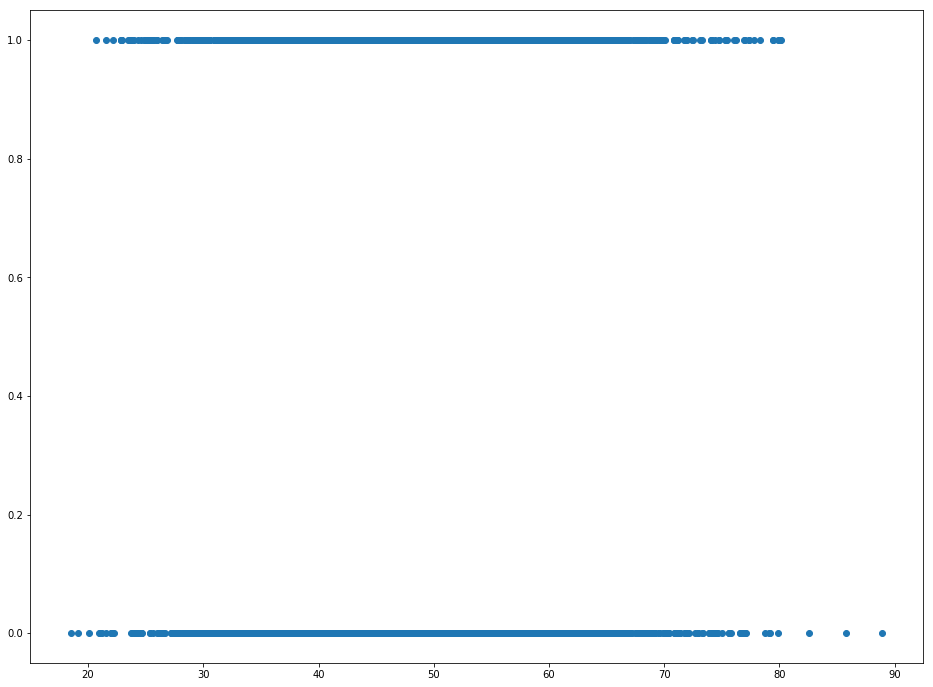

In [28]:
import matplotlib.pyplot as plt
data = data.sample(n=10000)
plt.figure(figsize=(16, 12))
# evenly sampled time at 200ms intervals
Y = np.array(data["returnShipment"])
ageNummArray = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data['dateOfBirth']]
X = np.array([ d for d in ageNummArray])
# red dashes, blue squares and green triangles
plt.plot(X, Y, linestyle="",marker="o")
plt.show()

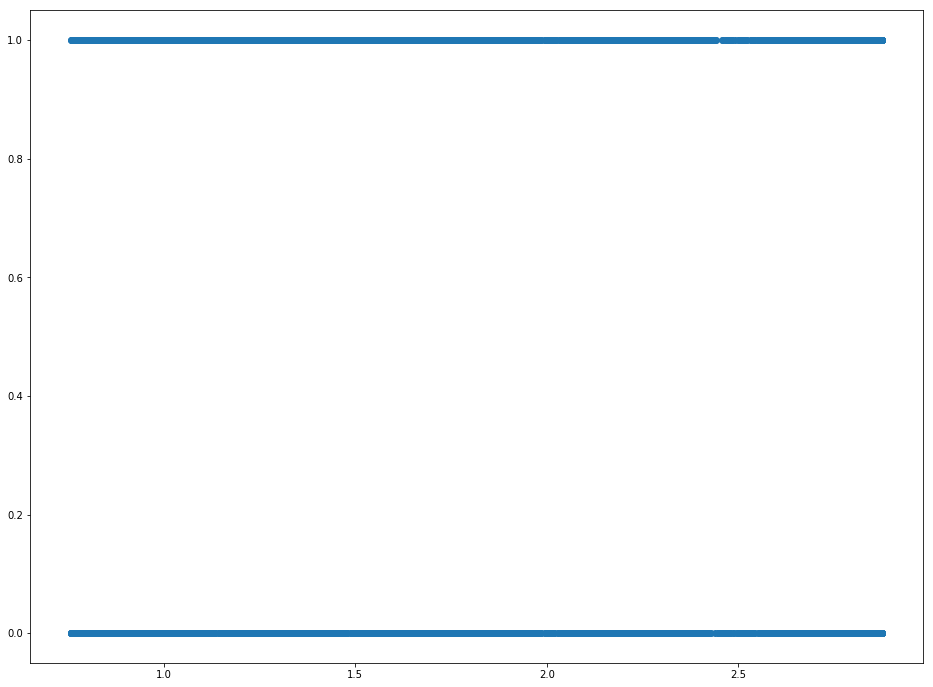

In [30]:
plt.figure(figsize=(16, 12))
# evenly sampled time at 200ms intervals
Y = np.array(data["returnShipment"])
accountAge = [((datetime.strptime("2014-01-01", '%Y-%m-%d')-datetime.strptime(d, '%Y-%m-%d'))/timedelta (days=1))/365 for d in data["creationDate"]]
X = np.array([d for d in accountAge])
# red dashes, blue squares and green triangles
plt.plot(X, Y, linestyle="",marker="o")
plt.show()

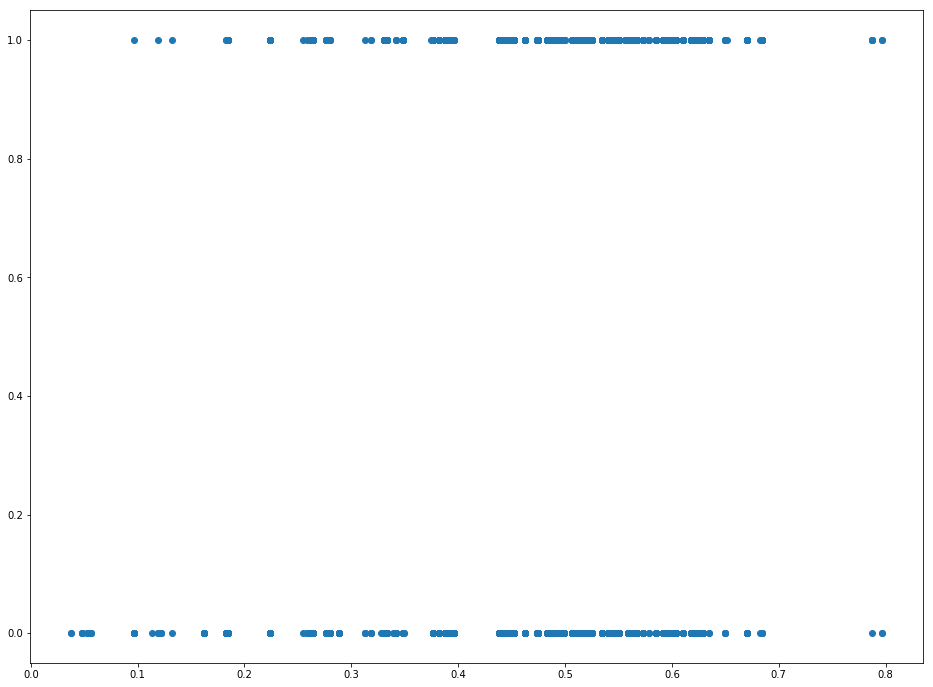

In [31]:
plt.figure(figsize=(16, 12))
# evenly sampled time at 200ms intervals
Y = np.array(data["returnShipment"])
X = np.array([(mDict[str(d) + "-1"] + 5)/(mDict[str(d) + "-1"] + 10 + mDict[str(d) + "-0"] ) for d in data['manufacturerID'] ])
# red dashes, blue squares and green triangles
plt.plot(X, Y, linestyle="",marker="o")
plt.show()

In [43]:
asdf = np.array([(cDict[str(d) + "-1"] + 5)/(cDict[str(d) + "-1"] + 10 + cDict[str(d) + "-0"] ) for d in data['manufacturerID'] ])

In [44]:
min(asdf)

0.2222222222222222

In [45]:
max(asdf)

0.813953488372093

In [55]:
manuReturnRateF = np.array([calculateRisk(mDict[str(d) + "-0"], mDict[str(d) + "-1"]) for d in data['manufacturerID'] ])